In [2]:
# importamos wget y las librerías que nos faltan
from wget import download
from os import path
import pandas as pd
import numpy as np
#https://github.com/agustinbx/DataSet-Trabajo/winequality_BR.csv



# descargamos la base de datos
if not path.exists("winequality_BR.csv"):
  download("https://github.com/agustinbx/DataSet-Trabajo/raw/main/winequality_BR.csv")
else:
  print("No vamos a bajar el archivo de itunes porque ya existe!")

No vamos a bajar el archivo de itunes porque ya existe!


In [3]:
raw_ds = pd.read_csv("winequality_BR.csv", delimiter=';')
winesDf = raw_ds.copy()
winesDf

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,Riesling,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,NaN,NaN,NaN
1,Riesling,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,NaN,NaN,NaN
2,Riesling,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,NaN,NaN,NaN
3,Riesling,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,NaN,NaN,NaN
4,Riesling,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,Garnacha,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,NaN,NaN,NaN
3228,Garnacha,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,NaN,NaN,NaN
3229,Garnacha,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11,6,NaN,NaN,NaN
3230,Garnacha,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,NaN,NaN,NaN


Elimino las columnas que son nulas y las id ya que son innecesarias y complican el analisis

In [4]:
winesDf= winesDf.dropna(axis=1,how="all")
winesDf

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Riesling,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,Riesling,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,Riesling,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,Riesling,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,Riesling,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,Garnacha,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
3228,Garnacha,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
3229,Garnacha,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11,6
3230,Garnacha,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Inicio el analisis de los datos, primero necesito saber con que tipos de datos estoy trabajando y si estan en buen estado. ademas necesito saber si tengo valores faltantantes por lo que tambien corroboro que valores nulos tengo.

In [5]:
winesDf.isna().sum() #con esta linea de codigo verifico cuantos valores nulos tenemos en el csv y los sumo

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Este resultado indica que no hay valores NaN en el csv. Por lo que continuo con el analisis de columnas.

In [6]:
winesDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3232 non-null   object 
 1   fixed acidity         3232 non-null   float64
 2   volatile acidity      3232 non-null   float64
 3   citric acid           3232 non-null   float64
 4   residual sugar        3232 non-null   float64
 5   chlorides             3232 non-null   float64
 6   free sulfur dioxide   3232 non-null   float64
 7   total sulfur dioxide  3232 non-null   float64
 8   density               3232 non-null   float64
 9   pH                    3232 non-null   float64
 10  sulphates             3232 non-null   float64
 11  alcohol               3232 non-null   object 
 12  quality               3232 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 328.4+ KB


type: tipo de uva con la que se elabora el vino. 

fixed acidity: cantidad de ácidos no volátiles presentes en el vino, medida en gramos por litro.

volatile acidity: cantidad de ácidos volátiles presentes en el vino, medida en gramos por litro. 

citric acid: contenido de ácido cítrico en el vino, medido en gramos por litro.

residual sugar: cantidad de azúcar que queda en el vino después de la fermentación, medida en gramos por litro. 

chlorides: concentración de cloruros (sales) en el vino, medida en gramos por litro.

free sulfur dioxide: cantidad de dióxido de azufre que no está ligado químicamente en el vino, medida en miligramos por litro. 

total sulfur dioxide: suma del dióxido de azufre libre y el combinado en el vino, medida en miligramos por litro.

density: medida de la masa por unidad de volumen del vino, utilizada para estimar la concentración de sólidos disueltos, medida en gramos por centímetro cúbico.

pH: medida de la acidez o alcalinidad del vino. 

sulphates: concentración de sales de sulfato en el vino, medida en gramos por litro.

alcohol: contenido alcohólico del vino, medido en porcentaje de volumen (% vol).

quality: puntuación del vino, con una escala que va de 0 a 10.


Hay una inconsistencia y una mejora posible para los datos
    
    -En cuanto a la columna type, esta es representada por pandas como object debido a que contiene strings, pero al ser estas strings siempre las mismas pandas permite tranformar el tipo de dato a category el cual es mas eficiente en estos casos en terminos de rendimiento.

    -En lo que a la columna alcohol refiere esta esta representada por el tipo object siendo que esta deberia ser de float64, esto posiblemente se deba a que alcohol contenga valores que pandas no puede intepretar como numeros. Por lo cual se debe hallar estos valores y decidir que hacer con ellos.

    Garnacha;11.6;0.475;0.4;1.4;0.091;6;28;0.99704;3.07;0.65;100.333.333.333.333;6;;;
    Garnacha;11.6;0.475;0.4;1.4;0.091;6;28;0.99704;3.07;0.65;100.333.333.333.333;6;;;


In [7]:
#convierto los datos erroneos en NaN
winesDf["alcohol"] = pd.to_numeric(winesDf["alcohol"],errors='coerce')

winesDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3232 non-null   object 
 1   fixed acidity         3232 non-null   float64
 2   volatile acidity      3232 non-null   float64
 3   citric acid           3232 non-null   float64
 4   residual sugar        3232 non-null   float64
 5   chlorides             3232 non-null   float64
 6   free sulfur dioxide   3232 non-null   float64
 7   total sulfur dioxide  3232 non-null   float64
 8   density               3232 non-null   float64
 9   pH                    3232 non-null   float64
 10  sulphates             3232 non-null   float64
 11  alcohol               3226 non-null   float64
 12  quality               3232 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 328.4+ KB


C:\Users\usuario\AppData\Local\Temp\ipykernel_12088\3321118373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winesDf["alcohol"] = pd.to_numeric(winesDf["alcohol"],errors='coerce')


In [8]:
#calculo el promedio de % de volumen alcoholico entre los vinos de los cuales si tengo los datos
prom = winesDf['alcohol'].mean()
winesDf['alcohol'].fillna(prom,inplace= True)
winesDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3232 non-null   object 
 1   fixed acidity         3232 non-null   float64
 2   volatile acidity      3232 non-null   float64
 3   citric acid           3232 non-null   float64
 4   residual sugar        3232 non-null   float64
 5   chlorides             3232 non-null   float64
 6   free sulfur dioxide   3232 non-null   float64
 7   total sulfur dioxide  3232 non-null   float64
 8   density               3232 non-null   float64
 9   pH                    3232 non-null   float64
 10  sulphates             3232 non-null   float64
 11  alcohol               3232 non-null   float64
 12  quality               3232 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 328.4+ KB


C:\Users\usuario\AppData\Local\Temp\ipykernel_12088\1711621962.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  winesDf['alcohol'].fillna(prom,inplace= True)
C:\Users\usuario\AppData\Local\Temp\ipykernel_12088\1711621962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winesDf['alcohol'].fillna(prom,inplace= True)


In [9]:
winesDf.loc[winesDf['density'] > 2, 'density'] = np.nan
mean_density = winesDf['density'].mean()
winesDf['density'].fillna(mean_density, inplace=True)
winesDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3232 non-null   object 
 1   fixed acidity         3232 non-null   float64
 2   volatile acidity      3232 non-null   float64
 3   citric acid           3232 non-null   float64
 4   residual sugar        3232 non-null   float64
 5   chlorides             3232 non-null   float64
 6   free sulfur dioxide   3232 non-null   float64
 7   total sulfur dioxide  3232 non-null   float64
 8   density               3232 non-null   float64
 9   pH                    3232 non-null   float64
 10  sulphates             3232 non-null   float64
 11  alcohol               3232 non-null   float64
 12  quality               3232 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 328.4+ KB


C:\Users\usuario\AppData\Local\Temp\ipykernel_12088\3251030495.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  winesDf['density'].fillna(mean_density, inplace=True)
C:\Users\usuario\AppData\Local\Temp\ipykernel_12088\3251030495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winesDf['density'].fillna(mean_density, inplace=True)


In [10]:
import pandas_profiling as pp

#generamos el reporte
report = pp.ProfileReport(winesDf)

# lo mostramos interactivo en nuestra notebook
#report.to_notebook_iframe()

#descarga el archivo html (lo abrimos desde google)
#report.to_file(output_file="Profile_report_winequality.html")



C:\Users\usuario\AppData\Local\Temp\ipykernel_12088\868166839.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


La correlación es un concepto estadístico que indica la dirección y la fuerza de la relación entre dos variables. Cuando dos variables están correlacionadas, significa que los cambios en una de ellas están asociados con cambios en la otra. Esta asociación puede ser positiva (cuando una variable aumenta, la otra también lo hace) o negativa (cuando una variable aumenta, la otra disminuye).

El coeficiente de correlación de Pearson es la medida más utilizada para cuantificar esta relación. Se representa con la letra  r  y toma valores entre -1 y 1. Un valor de  r  cercano a 1 indica una fuerte correlación positiva, mientras que un valor cercano a -1 indica una fuerte correlación negativa. Un valor cercano a 0 sugiere que no hay una correlación lineal evidente entre las variables.

Correlación no implica causalidad. Dos variables pueden estar correlacionadas sin que una cause necesariamente la otra.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Generamos la matriz de correlacion, teniendo en cuenta unicamente valores numericos
numeric_data = winesDf.select_dtypes(include=[np.number])
#numeric_data = numeric_data.dropna()
correlation_matrix = numeric_data.corr()

correlation_matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.126716,0.394672,-0.141115,0.259318,-0.320718,-0.368046,0.426108,-0.367687,0.308982,-0.004170,-0.017376
volatile acidity,0.126716,1.000000,-0.499696,-0.244183,0.358063,-0.395617,-0.471719,0.320972,0.284583,0.203200,-0.055407,-0.320769
citric acid,0.394672,-0.499696,1.000000,0.216785,0.007385,0.184881,0.247508,0.047059,-0.460677,0.040120,0.032792,0.152035
residual sugar,-0.141115,-0.244183,0.216785,1.000000,-0.175712,0.518635,0.562273,0.380135,-0.268701,-0.231172,-0.319939,-0.036492
chlorides,0.259318,0.358063,0.007385,-0.175712,1.000000,-0.233314,-0.328603,0.350057,-0.006688,0.458424,-0.176842,-0.191086
free sulfur dioxide,-0.320718,-0.395617,0.184881,0.518635,-0.233314,1.000000,0.781888,-0.054224,-0.175219,-0.263815,-0.209860,0.078706
total sulfur dioxide,-0.368046,-0.471719,0.247508,0.562273,-0.328603,0.781888,1.000000,-0.135114,-0.296255,-0.347544,-0.247720,0.017726
density,0.426108,0.320972,0.047059,0.380135,0.350057,-0.054224,-0.135114,1.000000,-0.012254,0.294760,-0.567200,-0.305091
pH,-0.367687,0.284583,-0.460677,-0.268701,-0.006688,-0.175219,-0.296255,-0.012254,1.000000,0.132974,0.195835,0.040946
sulphates,0.308982,0.203200,0.040120,-0.231172,0.458424,-0.263815,-0.347544,0.294760,0.132974,1.000000,0.072560,0.067959


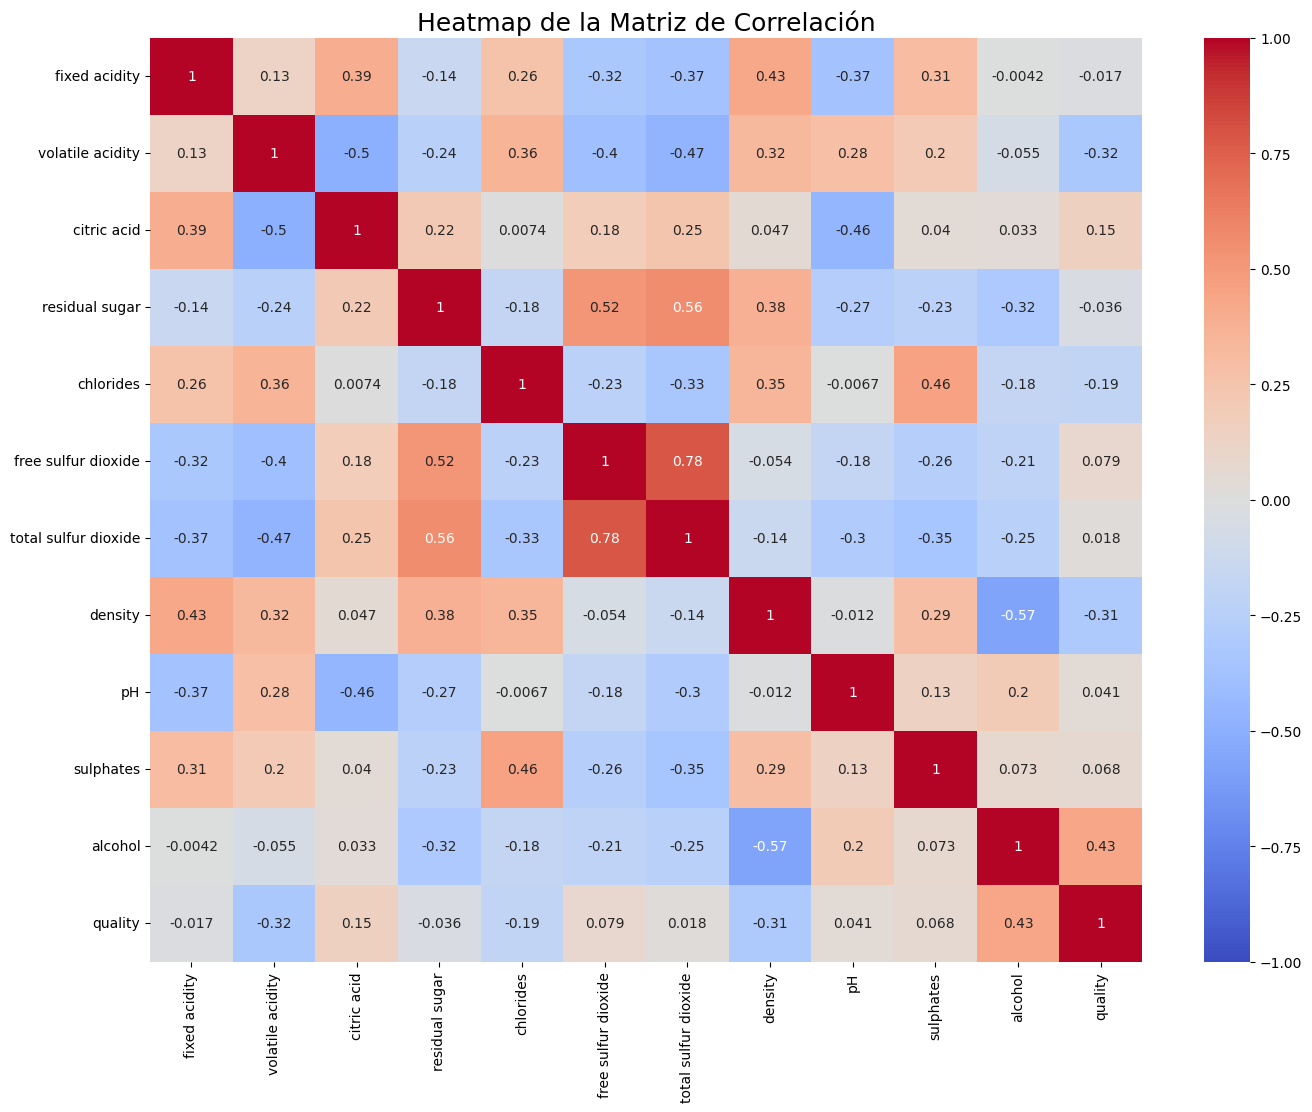

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
#imprimimos la matriz como un heatmap
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, vmin=-1.0, vmax=1.0, center=0.0, annot=True, cmap='coolwarm')
plt.title('Heatmap de la Matriz de Correlación', fontsize=18)
plt.show()

Una regla de esas que no tienen demostración pero que funciona bastante bien (el término en inglés para definirlas es "rules of thumb") dice que si la correlación da por encima de 0.7 (o por debajo de -0.7), la relación entre esas dos variables merece un poco de análisis extra.

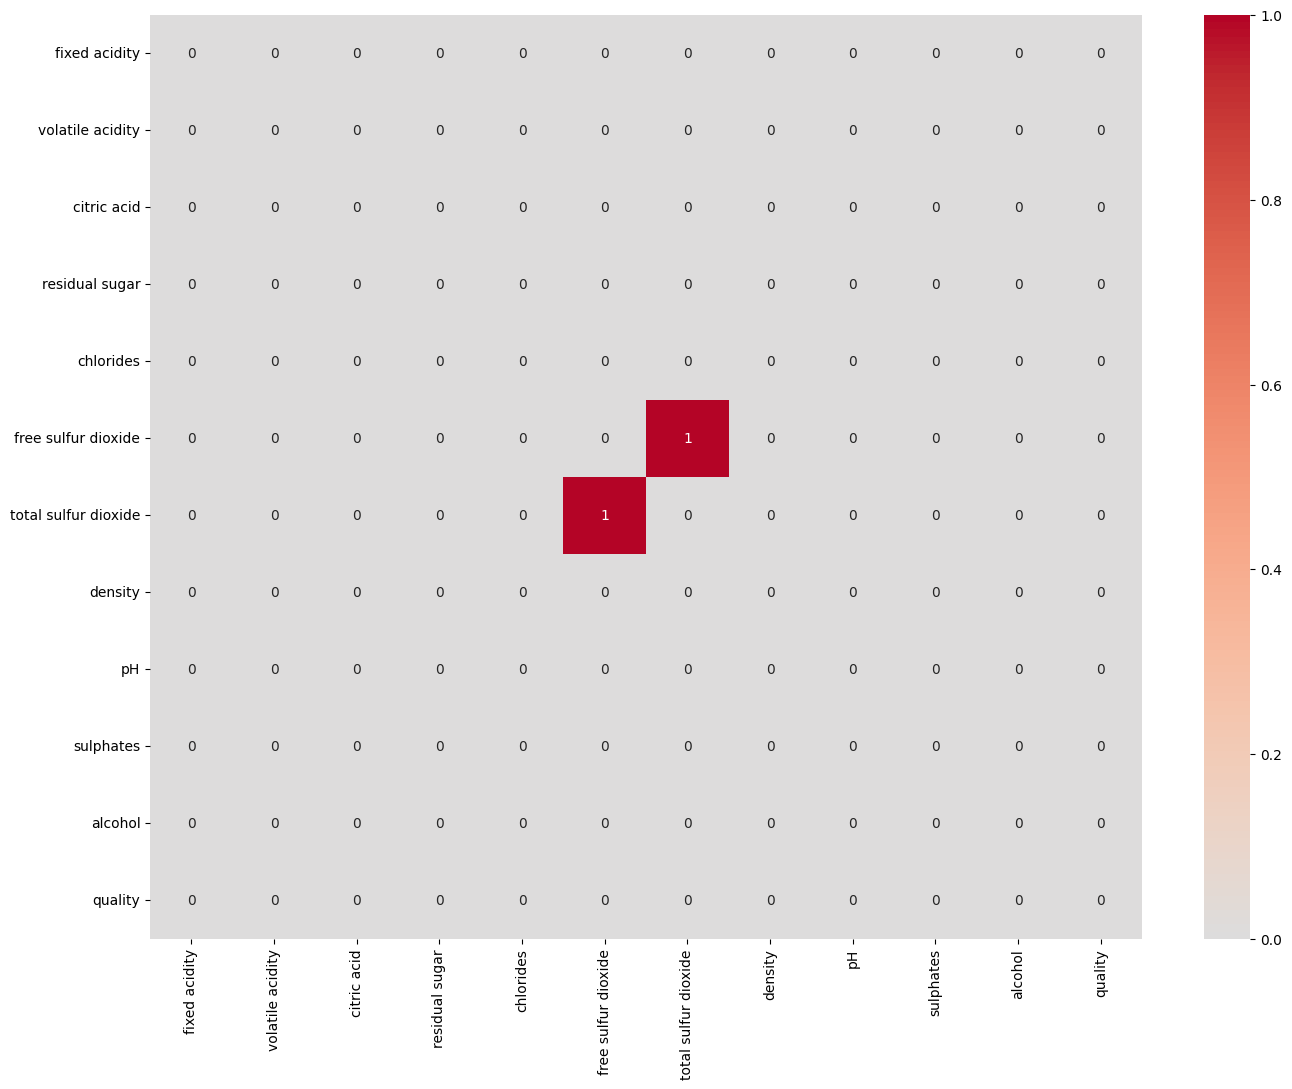

In [13]:
# tomamos el valor absoluto de las correlaciones, umbralamos las mayores a 0.7
correlation_matrix_umbralizada = correlation_matrix.abs() > 0.7 

# aprovechamos y sacamos la diagonal
np.fill_diagonal(correlation_matrix_umbralizada.values, 0)

# e imprimimos la matriz como un heatmap
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix_umbralizada, vmin=0.0, vmax=1.0, center=0.0, annot=True, cmap= 'coolwarm')
plt.show()

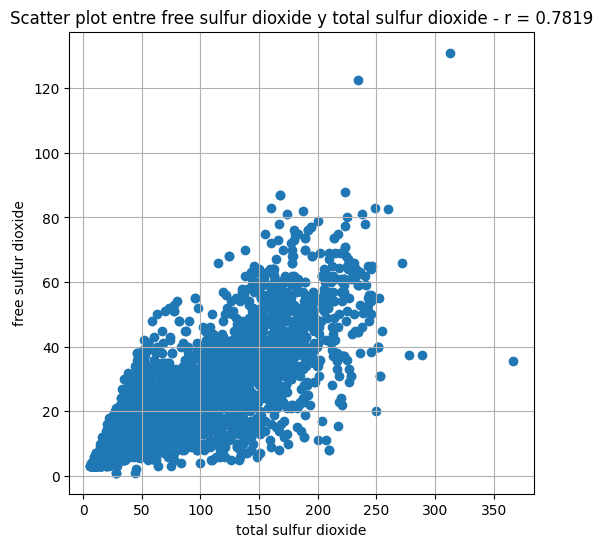

In [14]:
# iteramos por cada una de las columnas
for i, col in enumerate(correlation_matrix_umbralizada.columns):
  # y por cada una de las filas (para eso usamos el índice)
  for j in range(i,len(correlation_matrix_umbralizada.index)):
    # extraemos el nombre de la fila en la que estamos
    row = correlation_matrix_umbralizada.index[j]
    # si en esa posición tenemos un True en la matriz umbralizada
    if correlation_matrix_umbralizada.loc[row, col]:
      # nos traemos el valor de esa correlación
      correlation = correlation_matrix.loc[row, col]
      # representamos en un scatter plot cuadrado los valores de ambas variables
      plt.figure(figsize=(6, 6))
      plt.scatter(winesDf[row], winesDf[col])
      # y lo mostramos bonito
      plt.title(f"Scatter plot entre {col} y {row} - r = {correlation:.4f}")
      plt.xlabel(row)
      plt.ylabel(col)
      plt.grid(True)
      plt.show()    

In [16]:
print(winesDf.columns)

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


OUTLIER ??????

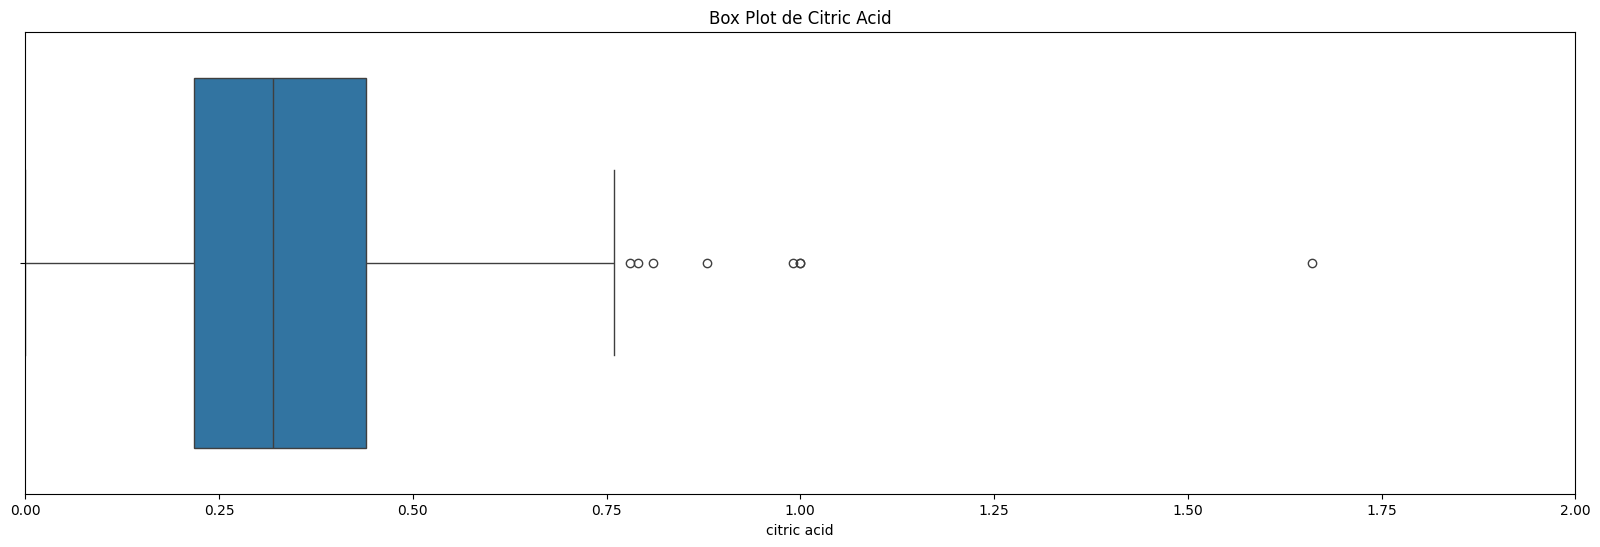

In [17]:
plt.figure(figsize=(20,6))  # Opcional, ajustar el tamaño de la figura
sns.boxplot(x=winesDf['citric acid'])  # Crear el Box Plot

plt.xlim(0, 2)  # Escala del eje x

plt.title('Box Plot de Citric Acid')  # Añadir título
plt.show()  # Mostrar el gráfico

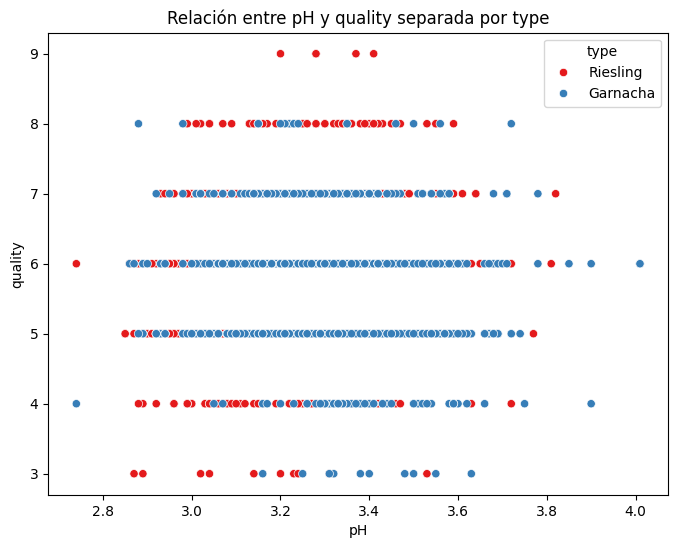

In [18]:
# Crear el gráfico de dispersión
plt.figure(figsize=(8,6))  # Ajustar el tamaño del gráfico
sns.scatterplot(x='pH', y='quality', hue='type', data=winesDf, palette='Set1')  # Usar hue para diferenciar por type

# Añadir títulos y etiquetas
plt.title('Relación entre pH y quality separada por type')
plt.xlabel('pH')
plt.ylabel('quality')

plt.show()


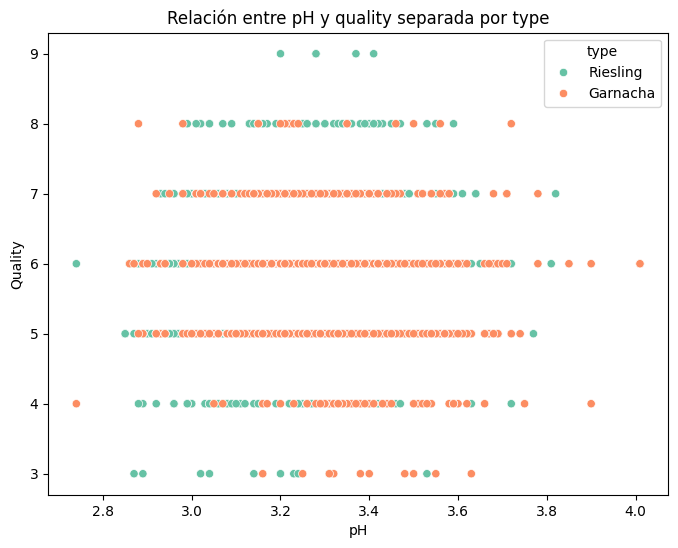

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='pH', y='quality', hue='type', data=winesDf, palette='Set2')

plt.title('Relación entre pH y quality separada por type')
plt.xlabel('pH')
plt.ylabel('Quality')

plt.show()

RELACION DE DENSIDAD Y SULFATOS SEPARADO POR TIPO.

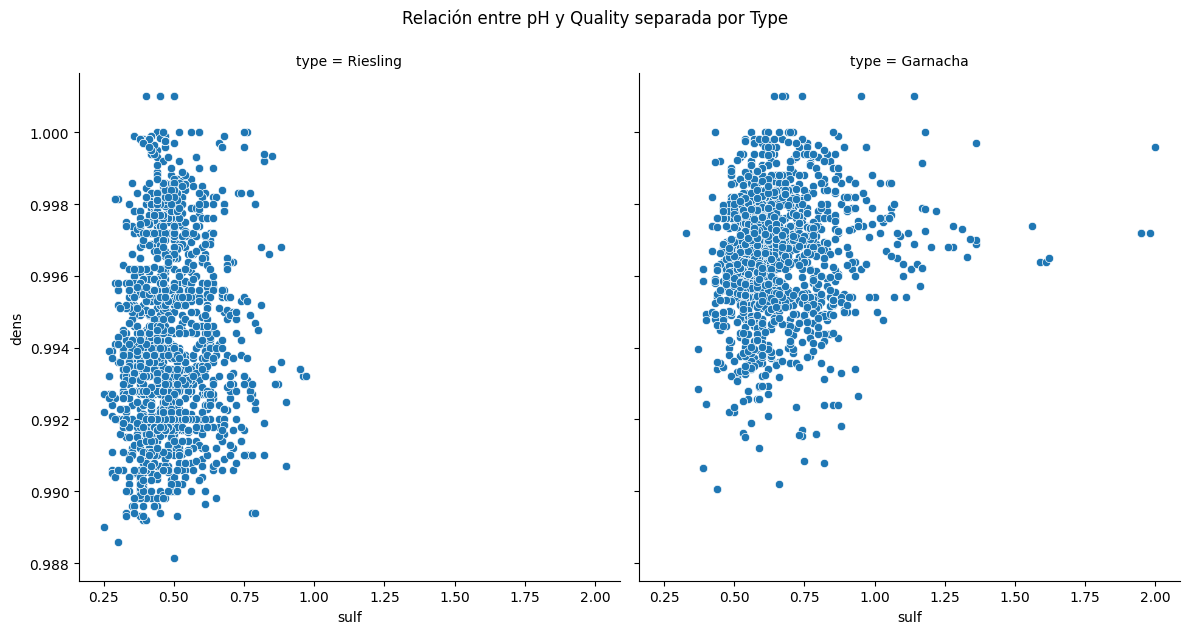

In [20]:
tintos = winesDf[winesDf['type'] == 'Garnacha']
blancos = winesDf[winesDf['type'] == 'Riesling']

# Crear un FacetGrid
g = sns.FacetGrid(winesDf, col='type', height=6, aspect=1)
g.map(sns.scatterplot, 'sulphates', 'density')

# Añadir etiquetas y título
g.set_axis_labels('sulf', 'dens')
g.fig.suptitle('Relación entre pH y Quality separada por Type', y=1.05)

plt.show()



residual sugar: cantidad de azúcar que queda en el vino después de la fermentación, medida en gramos por litro.

Los vinos blancos tienen mayor cantidad de azúcar residual (residual sugar) que los vinos tintos.

Justificación: Los vinos blancos suelen ser más dulces que los tintos, lo que podría reflejarse en mayores niveles de azúcar residual. 

Explayar mas con los datos del grafico y el describe.

HIPOTESIS FALOPA, NOSE SI ES LA IDEA. CAPAZ SIRVE.



Azucar Residual en vinos tintos (Garnacha):
count    1599.000000
mean        2.538806
std         1.409928
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64

Azucar Residual en vinos blancos (Riesling):
count    1633.000000
mean        6.031843
std         4.988856
min         0.800000
25%         1.600000
50%         4.700000
75%         9.300000
max        23.500000
Name: residual sugar, dtype: float64


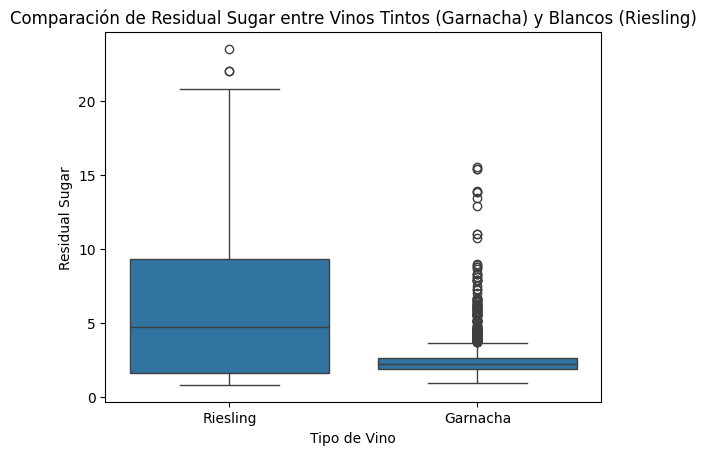

In [21]:
tintos = winesDf[winesDf['type'] == 'Garnacha']
blancos = winesDf[winesDf['type'] == 'Riesling']


# Calcular estadísticas descriptivas de la acidez fija
print("Azucar Residual en vinos tintos (Garnacha):")
print(tintos['residual sugar'].describe())

print("\nAzucar Residual en vinos blancos (Riesling):")
print(blancos['residual sugar'].describe())


import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para comparar la acidez fija en ambos tipos de vino
sns.boxplot(x='type', y='residual sugar', data=winesDf)
plt.title('Comparación de Residual Sugar entre Vinos Tintos (Garnacha) y Blancos (Riesling)')
plt.xlabel('Tipo de Vino')
plt.ylabel('Residual Sugar')
plt.show()

free sulfur dioxide: cantidad de dióxido de azufre que no está ligado químicamente en el vino, medida en miligramos por litro. 

El dióxido de azufre libre (free sulfur dioxide) es más alto en los vinos blancos que en los tintos.

Justificación: El dióxido de azufre es un conservante comúnmente más usado en los vinos blancos para evitar la oxidación.

OTRA HIPOTESIS FALOPA, CAPAZ SIRVE, ANALIZAR EL GRAFICO, DESCRIBE, BUSCAR INFO DE LA VARIABLE


Dioxido de azufre libre en vinos tintos (Garnacha):
count    1599.000000
mean       15.874922
std        10.460157
min         1.000000
25%         7.000000
50%        14.000000
75%        21.000000
max        72.000000
Name: free sulfur dioxide, dtype: float64

Dioxido de azufre libre en vinos blancos (Riesling):
count    1633.000000
mean       34.846908
std        16.398945
min         3.000000
25%        23.000000
50%        34.000000
75%        46.000000
max       131.000000
Name: free sulfur dioxide, dtype: float64


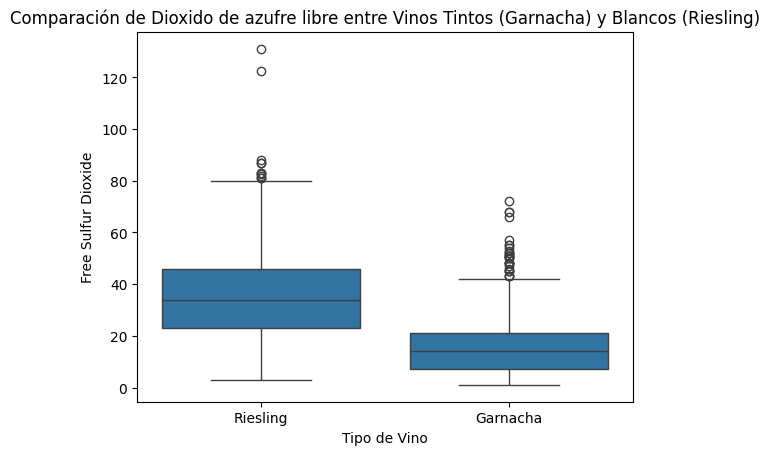

In [ ]:
# Calcular estadísticas descriptivas de la acidez fija
print("Dioxido de azufre libre en vinos tintos (Garnacha):")
print(tintos['free sulfur dioxide'].describe())

print("\nDioxido de azufre libre en vinos blancos (Riesling):")
print(blancos['free sulfur dioxide'].describe())


import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para comparar la acidez fija en ambos tipos de vino
sns.boxplot(x='type', y='free sulfur dioxide', data=winesDf)
plt.title('Comparación de Dioxido de azufre libre entre Vinos Tintos (Garnacha) y Blancos (Riesling)')
plt.xlabel('Tipo de Vino')
plt.ylabel('Free Sulfur Dioxide')
plt.show()

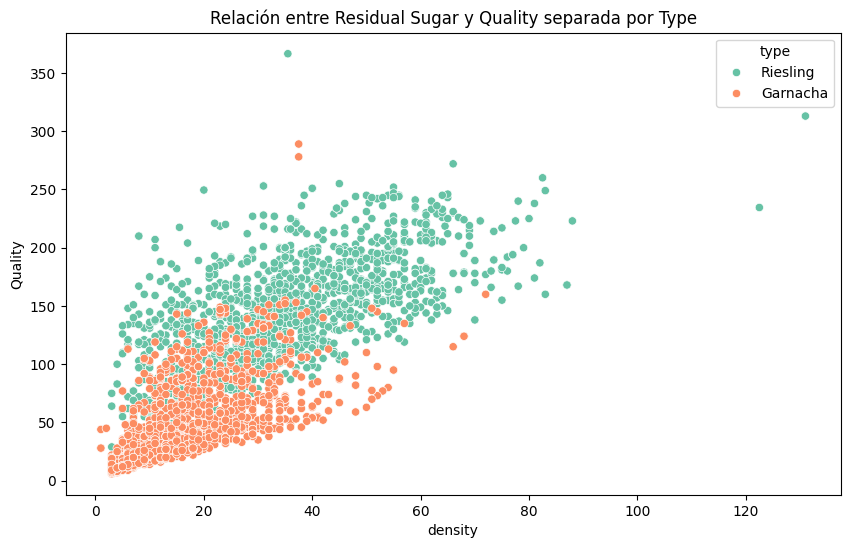

In [ ]:
# Crear el scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='free sulfur dioxide', y='total sulfur dioxide', hue='type', data=winesDf, palette='Set2')

# Añadir título y etiquetas
plt.title('Relación entre Residual Sugar y Quality separada por Type')
plt.xlabel('density')
plt.ylabel('Quality')

# Mostrar el gráfico
plt.show()

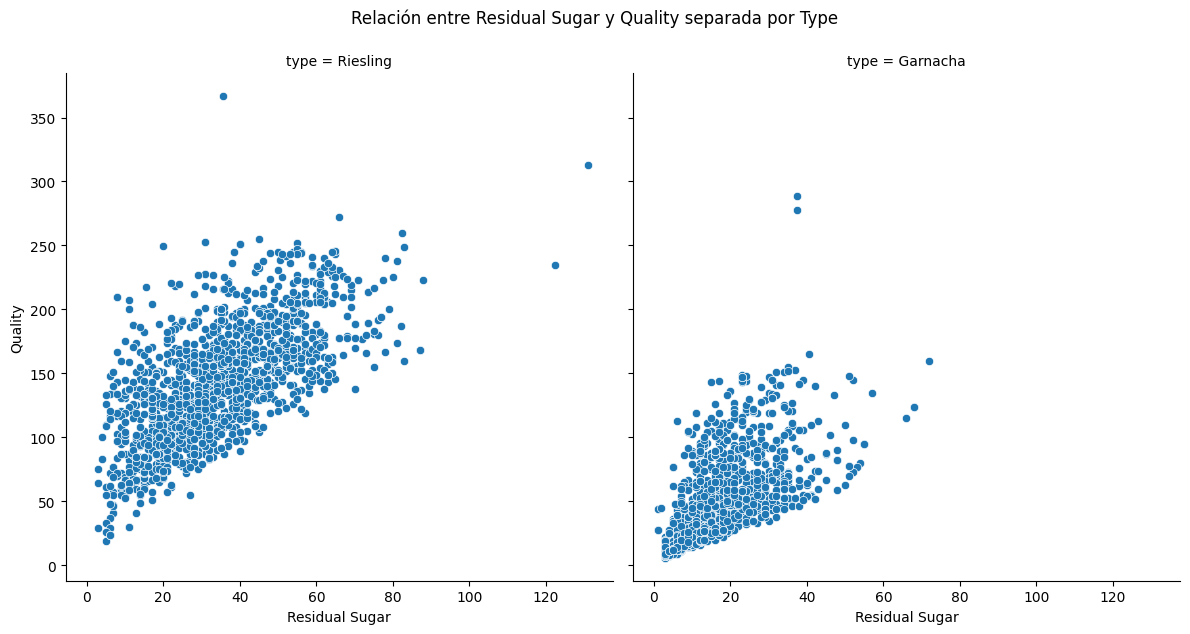

In [ ]:
# Crear un FacetGrid
g = sns.FacetGrid(winesDf, col='type', height=6, aspect=1)
g.map(sns.scatterplot, 'free sulfur dioxide', 'total sulfur dioxide')

# Añadir etiquetas y título
g.set_axis_labels('Residual Sugar', 'Quality')
g.fig.suptitle('Relación entre Residual Sugar y Quality separada por Type', y=1.05)

plt.show()

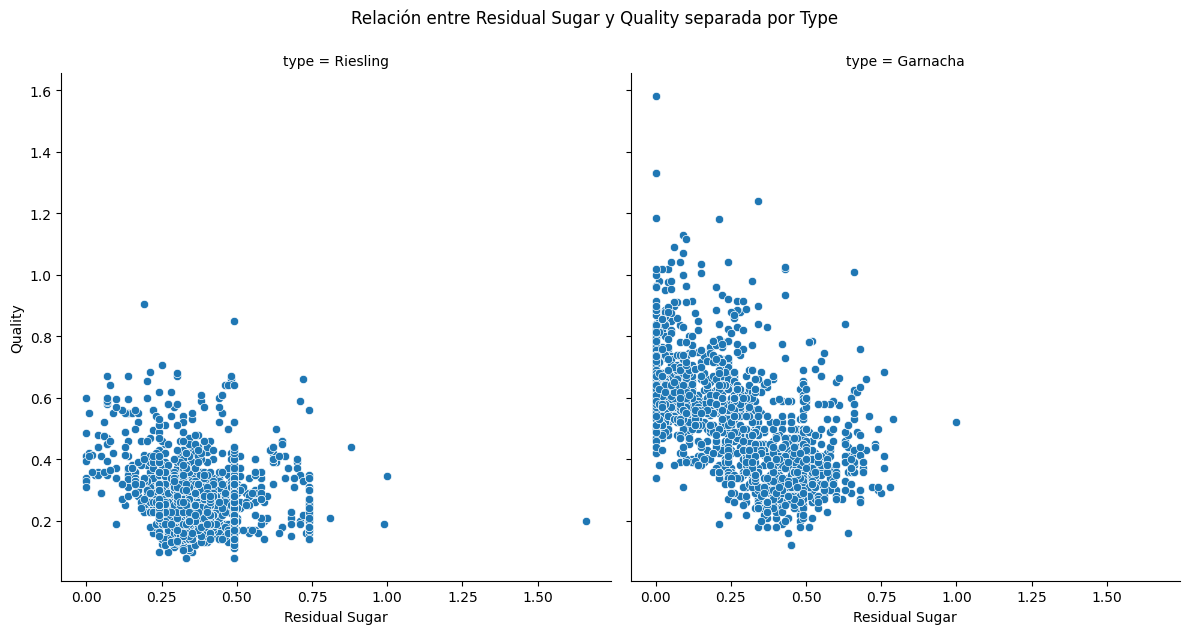

In [ ]:
# Crear un FacetGrid
g = sns.FacetGrid(winesDf, col='type', height=6, aspect=1)
g.map(sns.scatterplot, 'citric acid', 'volatile acidity')

# Añadir etiquetas y título
g.set_axis_labels('Residual Sugar', 'Quality')
g.fig.suptitle('Relación entre Residual Sugar y Quality separada por Type', y=1.05)

plt.show()

HIPOTESIS

Los vinos que utilizan el tipo de uva Garnacha son mas acidos que los vinos de tipo de uva Riesling?

Analizamos las columnas Fixed Acidity y Volatile Acidity separados por tipo.

En primer lugar vemos graficamente mediante box-plots que ocurre para cada caso.

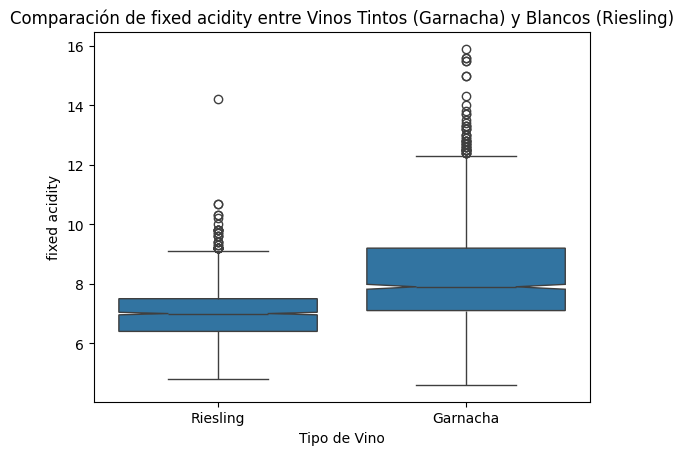

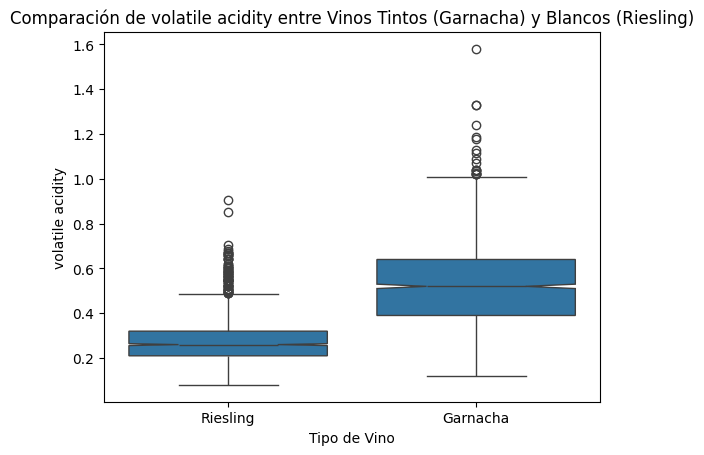

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para comparar la acidez fija en ambos tipos de vino
sns.boxplot(x='type', y='fixed acidity', data=winesDf, notch=True)
plt.title('Comparación de fixed acidity entre Vinos Tintos (Garnacha) y Blancos (Riesling)')
plt.xlabel('Tipo de Vino')
plt.ylabel('fixed acidity')
plt.show()

# Crear un boxplot para comparar la acidez fija en ambos tipos de vino
sns.boxplot(x='type', y='volatile acidity', data=winesDf, notch=True)
plt.title('Comparación de volatile acidity entre Vinos Tintos (Garnacha) y Blancos (Riesling)')
plt.xlabel('Tipo de Vino')
plt.ylabel('volatile acidity')
plt.show()


Notamos una diferencia en los graficos.

Para validar la hipotesis, podemos usar test T, pero primero hay que validar Normalidad de los datos a traves de Shapiro Wilk

In [ ]:
from scipy.stats import shapiro

# Separamos los datos en dos grupos, desarrollados y en vías de desarrollo
garnacha = winesDf[winesDf['type'] == 'Garnacha']['fixed acidity']
riesling = winesDf[winesDf['type'] == 'Riesling']['fixed acidity']

# Test de Shapiro-Wilk para países desarrollados
stat, p = shapiro(garnacha)
print(f"Test de Shapiro-Wilk para vinos garnacha: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(riesling)
print(f"Test de Shapiro-Wilk para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para vinos garnacha: Estadístico=0.942, p-valor=0.000
Test de Shapiro-Wilk para vinos riesling: Estadístico=0.967, p-valor=0.000


Como obtenemos un p-valor menor a 0.05, estamos ante datos que no respetan una distribucion normal.

(tambien se puede probar por Kolmogorov-Smirnov. Este test es mas general y menos potente para detectar desviaciones sutiles de normalidad)



In [ ]:
from scipy.stats import kstest

# Test de Kolmogorov-Smirnov para países desarrollados
stat, p = kstest(garnacha, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Kolmogorov-Smirnov para países en vías de desarrollo
stat, p = kstest(riesling, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Kolmogorov-Smirnov para vinos riesling: Estadístico=1.000, p-valor=0.000
Test de Kolmogorov-Smirnov para vinos riesling: Estadístico=1.000, p-valor=0.000


Analizamos el QQ plot. Si los puntos estan muy cerca de la linea, hay normalidad.



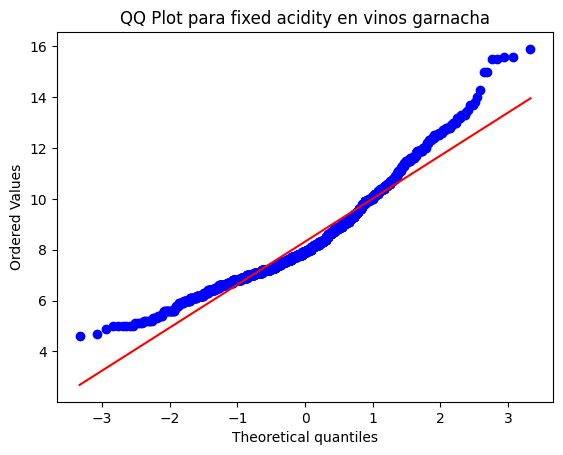

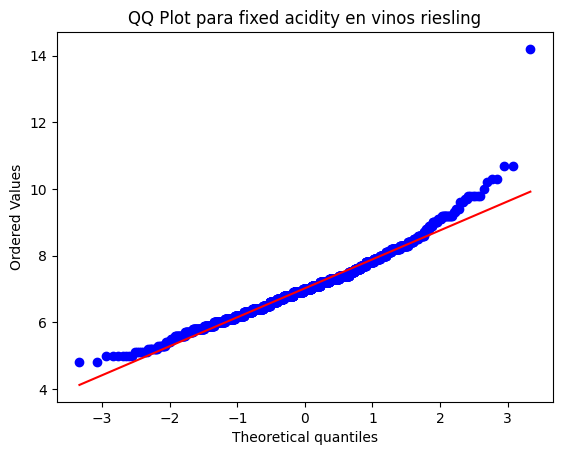

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# QQ plot para países desarrollados
stats.probplot(garnacha, dist="norm", plot=plt)
plt.title("QQ Plot para fixed acidity en vinos garnacha")
plt.show()

# QQ plot para países en vías de desarrollo
stats.probplot(riesling, dist="norm", plot=plt)
plt.title("QQ Plot para fixed acidity en vinos riesling")
plt.show()

Como ninguno de estos casos nos dieron lo que queremos, no podemos usar test T.

Probamos homocedasticidad (homogeneidad de varianzas) utilizando Levene. 

In [ ]:
stat, p = stats.levene(garnacha, riesling)
print(f"Test de Levene para fixed acidity: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para fixed acidity: Estadístico=384.206, p-valor=0.000


Como nos dio un p-valor menor a 0.05 tenemos datos que no son homocedasticos.

Validamos con Kruskal Wallis (con alpha 0.05)

In [ ]:
# Test de Kruskal-Wallis para comparar GDP_per_capita entre países desarrollados y en vías de desarrollo
stat, p = stats.kruskal(garnacha, riesling)
print(f"Test de Kruskal-Wallis para fixed acidity: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en el fixed acidity entre vinos garnacha y vinos riesling.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en el fixed acidity entre vinos garnacha y vinos riesling.")

Test de Kruskal-Wallis para fixed acidity: Estadístico=588.195, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa en el fixed acidity entre vinos garnacha y vinos riesling.


como nos dio un p-valor muy chico existen diferencias estadisticamente significativas entre los valores que estamos comparando.


Hacemos lo mismo para la variable volatile acidity

Box-Plot

Shapiro Wilk

QQ plot

Levene 

Kruskal wallis


In [ ]:
# Separamos los datos en dos grupos, desarrollados y en vías de desarrollo
garnacha2 = winesDf[winesDf['type'] == 'Garnacha']['volatile acidity']
riesling2 = winesDf[winesDf['type'] == 'Riesling']['volatile acidity']

# Test de Shapiro-Wilk para países desarrollados
stat, p = shapiro(garnacha2)
print(f"Test de Shapiro-Wilk para vinos garnacha: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(riesling2)
print(f"Test de Shapiro-Wilk para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para vinos garnacha: Estadístico=0.974, p-valor=0.000
Test de Shapiro-Wilk para vinos riesling: Estadístico=0.909, p-valor=0.000


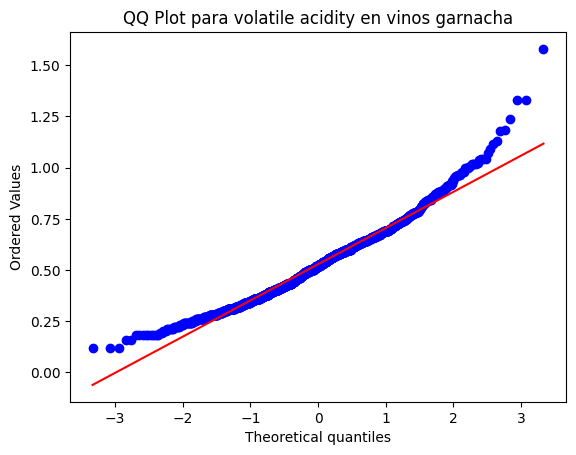

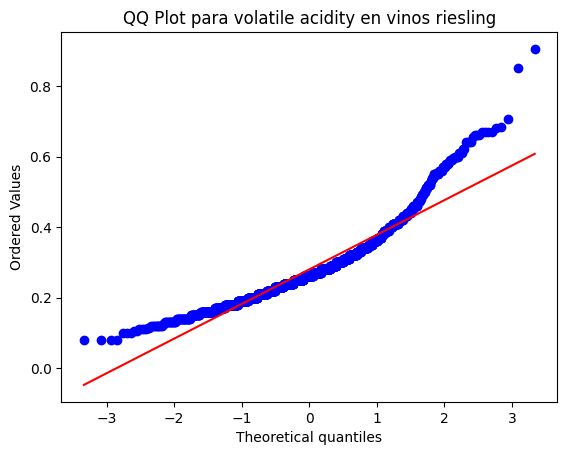

In [ ]:
# QQ plot para países desarrollados
stats.probplot(garnacha2, dist="norm", plot=plt)
plt.title("QQ Plot para volatile acidity en vinos garnacha")
plt.show()

# QQ plot para países en vías de desarrollo
stats.probplot(riesling2, dist="norm", plot=plt)
plt.title("QQ Plot para volatile acidity en vinos riesling")
plt.show()

In [ ]:
stat, p = stats.levene(garnacha2, riesling2)
print(f"Test de Levene para volatile acidity: Estadístico={stat:.3f}, p-valor={p:.3f}")


# Test de Kruskal-Wallis para comparar GDP_per_capita entre países desarrollados y en vías de desarrollo
stat, p = stats.kruskal(garnacha2, riesling2)
print(f"Test de Kruskal-Wallis para volatile acidity: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en el volatile acidity entre vinos garnacha y vinos riesling.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en el volatile acidity entre vinos garnacha y vinos riesling.")


Test de Levene para fixed acidity: Estadístico=437.749, p-valor=0.000
Test de Kruskal-Wallis para fixed acidity: Estadístico=1533.057, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa en el fixed acidity entre vinos garnacha y vinos riesling.


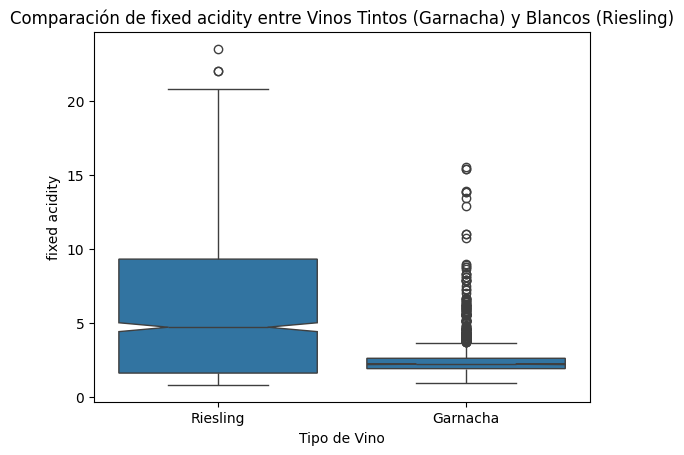

In [ ]:
# Crear un boxplot para comparar la acidez fija en ambos tipos de vino
sns.boxplot(x='type', y='residual sugar', data=winesDf, notch=True)
plt.title('Comparación de volatile acidity entre Vinos Tintos (Garnacha) y Blancos (Riesling)')
plt.xlabel('Tipo de Vino')
plt.ylabel('volatiles acidity')
plt.show()

In [ ]:
# Separamos los datos en dos grupos, Garnacha y Riesling
garnacha3 = winesDf[winesDf['type'] == 'Garnacha']['residual sugar']
riesling3 = winesDf[winesDf['type'] == 'Riesling']['residual sugar']

# Test de Shapiro-Wilk para países desarrollados
stat, p = shapiro(garnacha3)
print(f"Test de Shapiro-Wilk para vinos garnacha: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(riesling3)
print(f"Test de Shapiro-Wilk para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para vinos garnacha: Estadístico=0.566, p-valor=0.000
Test de Shapiro-Wilk para vinos riesling: Estadístico=0.872, p-valor=0.000


In [ ]:
# Test de Kolmogorov-Smirnov para vinos Garnacha
stat, p = kstest(garnacha3, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Kolmogorov-Smirnov para vinos Riesling
stat, p = kstest(riesling3, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos riesling: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Kolmogorov-Smirnov para vinos riesling: Estadístico=0.910, p-valor=0.000
Test de Kolmogorov-Smirnov para vinos riesling: Estadístico=0.831, p-valor=0.000


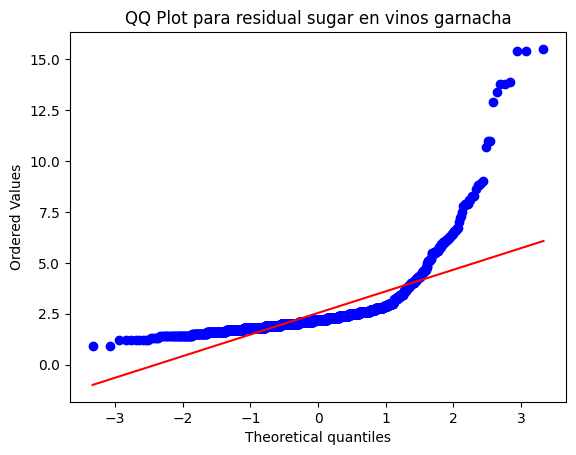

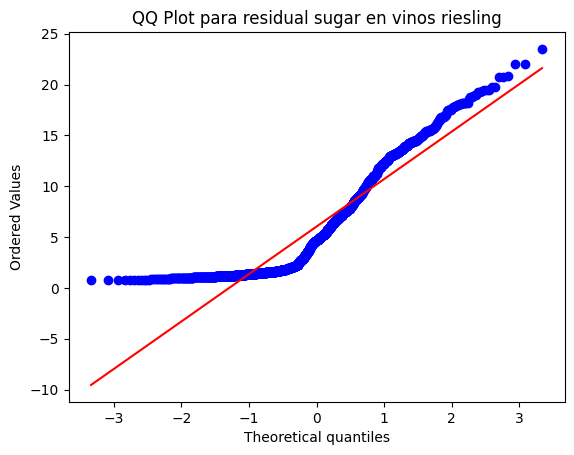

In [ ]:
# QQ plot para países desarrollados
stats.probplot(garnacha3, dist="norm", plot=plt)
plt.title("QQ Plot para residual sugar en vinos garnacha")
plt.show()

# QQ plot para países en vías de desarrollo
stats.probplot(riesling3, dist="norm", plot=plt)
plt.title("QQ Plot para residual sugar en vinos riesling")
plt.show()

In [ ]:
stat, p = stats.levene(garnacha3, riesling3)
print(f"Test de Levene para residual sugar: Estadístico={stat:.3f}, p-valor={p:.3f}")


# Test de Kruskal-Wallis para comparar GDP_per_capita entre países desarrollados y en vías de desarrollo
stat, p = stats.kruskal(garnacha3, riesling3)
print(f"Test de Kruskal-Wallis para residual sugar: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en el residual sugar entre vinos garnacha y vinos riesling.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en el residual sugar entre vinos garnacha y vinos riesling.")

Test de Levene para fixed acidity: Estadístico=1628.002, p-valor=0.000
Test de Kruskal-Wallis para fixed acidity: Estadístico=156.873, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa en el fixed acidity entre vinos garnacha y vinos riesling.


In [ ]:
import pandas as pd

# Supongamos que tu DataFrame original se llama winesDf
# Crear una copia del DataFrame
winesDf_copy = winesDf.copy()

# Añadir la columna 'quality_group' en la copia
winesDf_copy['quality_group'] = pd.cut(winesDf_copy['quality'], 
                                       bins=[0, 4, 7, 10], 
                                       labels=['Baja', 'Media', 'Alta'])


In [ ]:
winesDf_copy['quality_group'].value_counts()

quality_group
Media    3003
Baja      138
Alta       91
Name: count, dtype: int64

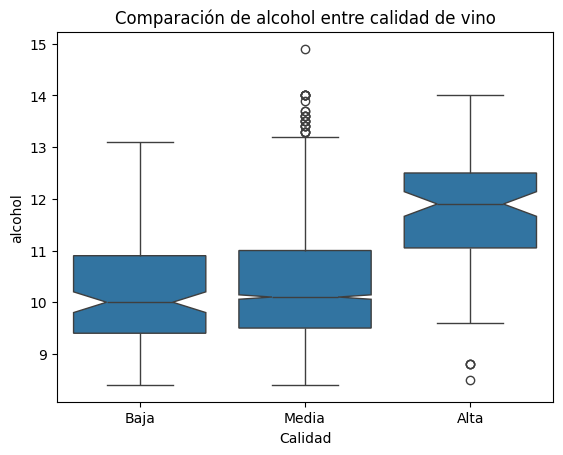

In [ ]:
# Crear un boxplot para comparar la acidez fija en ambos tipos de vino
sns.boxplot(x='quality_group', y='alcohol', data=winesDf_copy, notch=True)
plt.title('Comparación de alcohol entre calidad de vino')
plt.xlabel('Calidad')
plt.ylabel('alcohol')
plt.show()

In [ ]:
# Separamos los datos en dos grupos, desarrollados y en vías de desarrollo
vino_q_baja = winesDf_copy[winesDf_copy['quality_group'] == 'Baja']['alcohol']
vino_q_media = winesDf_copy[winesDf_copy['quality_group'] == 'Media']['alcohol']
vino_q_alta = winesDf_copy[winesDf_copy['quality_group'] == 'Alta']['alcohol']

# Test de Shapiro-Wilk para países desarrollados
stat, p = shapiro(vino_q_baja)
print(f"Test de Shapiro-Wilk para vinos Q baja: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(vino_q_media)
print(f"Test de Shapiro-Wilk para vinos Q media: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(vino_q_alta)
print(f"Test de Shapiro-Wilk para vinos Q alta: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para vinos Q baja: Estadístico=0.961, p-valor=0.001
Test de Shapiro-Wilk para vinos Q media: Estadístico=0.943, p-valor=0.000
Test de Shapiro-Wilk para vinos Q alta: Estadístico=0.942, p-valor=0.000


In [ ]:
stat, p = stats.levene(vino_q_baja, vino_q_media)
print(f"Test de Levene para baja-media: Estadístico={stat:.3f}, p-valor={p:.3f}")

stat, p = stats.levene(vino_q_baja, vino_q_alta)
print(f"Test de Levene para baja-alta: Estadístico={stat:.3f}, p-valor={p:.3f}")

stat, p = stats.levene(vino_q_media, vino_q_alta)
print(f"Test de Levene para media-alta: Estadístico={stat:.3f}, p-valor={p:.3f}")




Test de Levene para baja-media: Estadístico=2.347, p-valor=0.126
Test de Levene para baja-alta: Estadístico=1.284, p-valor=0.258
Test de Levene para media-alta: Estadístico=0.013, p-valor=0.911


In [ ]:
# Test de Kolmogorov-Smirnov para países desarrollados
stat, p = kstest(vino_q_baja, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos baja: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Kolmogorov-Smirnov para países en vías de desarrollo
stat, p = kstest(vino_q_media, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos media: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Kolmogorov-Smirnov para países desarrollados
stat, p = kstest(vino_q_alta, 'norm')
print(f"Test de Kolmogorov-Smirnov para vinos alta: Estadístico={stat:.3f}, p-valor={p:.3f}")


Test de Kolmogorov-Smirnov para vinos baja: Estadístico=1.000, p-valor=0.000
Test de Kolmogorov-Smirnov para vinos media: Estadístico=1.000, p-valor=0.000
Test de Kolmogorov-Smirnov para vinos alta: Estadístico=1.000, p-valor=0.000


In [ ]:
# Test de Mann-Whitney U para comparar Population_mln entre países desarrollados y en vías de desarrollo
stat, p = stats.mannwhitneyu(vino_q_baja, vino_q_media)
print(f"Test de Mann-Whitney U para Population_mln: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en los vinos de calidad baja y media.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en los vinos de calidad baja y media.")

print("-------------------------------------------------------------------------------")

# Test de Mann-Whitney U para comparar Population_mln entre países desarrollados y en vías de desarrollo
stat, p = stats.mannwhitneyu(vino_q_baja, vino_q_alta)
print(f"Test de Mann-Whitney U para Population_mln: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en los vinos de calidad baja y alta.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en los vinos de calidad baja y alta.")

print("-------------------------------------------------------------------------------")

# Test de Mann-Whitney U para comparar Population_mln entre países desarrollados y en vías de desarrollo
stat, p = stats.mannwhitneyu(vino_q_media, vino_q_alta)
print(f"Test de Mann-Whitney U para Population_mln: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en los vinos de calidad media y alta.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en los vinos de calidad media y alta.")

Test de Mann-Whitney U para Population_mln: Estadístico=189146.500, p-valor=0.083
No hay suficiente evidencia para rechazar la hipótesis nula.
No hay una diferencia significativa en los vinos de calidad baja y media.
-------------------------------------------------------------------------------
Test de Mann-Whitney U para Population_mln: Estadístico=1852.500, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa en los vinos de calidad baja y alta.
-------------------------------------------------------------------------------
Test de Mann-Whitney U para Population_mln: Estadístico=50132.500, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa en los vinos de calidad media y alta.


perplexity.ai - te da fuentes?

consensus.app - evidencia a favor y en contra de una afirmacion 

elicit.ai - parecida a la anterior

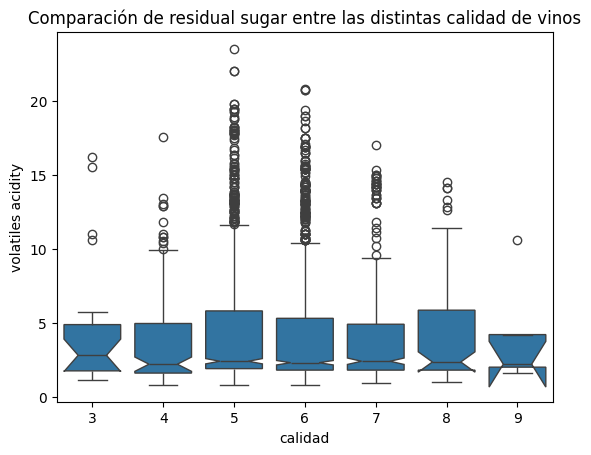

In [ ]:
# Crear un boxplot para comparar la residual sugar 
sns.boxplot(x='quality', y='residual sugar', data=winesDf, notch=True)
plt.title('Comparación de residual sugar entre las distintas calidad de vinos')
plt.xlabel('calidad')
plt.ylabel('volatiles acidity')
plt.show()